In [1]:
# This notebook generates the results in the paper and some additional plots just for fun.
# To get the results in section 3.1, set num_targets to 2. 
# To get the results in section 3.2, set num_targets to 10.

import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
from psrcal.losses import plot_reliability_diagram

from expected_cost.psrcal_wrappers import Brier, LogLoss, ECE, ECEbin, L2ECEbin, CalLoss

outdir = "outputs/"
utils.mkdir_p(outdir)


In [2]:
# Create the scores using a general method from the repository and map the names to those
# used in the paper.
num_targets = 10 # or 2 for the binary classification experiments
N = 200 * num_targets
feat_var = 0.08 if num_targets == 10 else 0.15
score_dict, targets = create_scores_for_expts(num_targets, N=N, P0=0.8, calibrate=True, simple_names=True, feat_var=feat_var, sim_name='gaussian_sim_md')

print(Brier(score_dict['cal'], targets))

# We have four different scores:
# cal: perfectly calibrated scores
# mcp: scores miscalibrated due to a mismatch in priors between the training and the test data
# mcs: scores miscalibrated due to (simulated) overfitting of the model
# mcps: scores miscalibrated due to both causes above

# We have three calibration models
# Affcal: affine transform of the log-posteriors
# Temcal: only scaling of the log-posteriors (same as above but without the shift)
# Hiscal: histogram binning, as done for ECE

# And two ways of training each of those models
# tt: train-on-test (cheating, as done for ECE)
# xv: cross-validation on the test data (non-cheating)   
    
# Create the three cost matrices used in the paper: 0-1 cost, 0-1 cost with abstention, and an 
# imbalanced cost matrix

cost_01  = ec.CostMatrix.zero_one_costs(num_targets)
cost_ab1 = ec.CostMatrix.zero_one_costs(num_targets, abstention_cost=0.1)

m = cost_01.get_matrix().copy()
m[num_targets-1,:] = 10
m[num_targets-1,num_targets-1] = 0
cost_im = ec.CostMatrix(m)

color = ['blue', 'red', 'green', 'yellow']
score_names = ['cal', 'mcp', 'mcs', 'mcps']

print(score_dict.keys())


0.3182481216001151
dict_keys(['cal', 'mcp', 'mcs', 'mcps', 'cal-affcalxv', 'mcp-affcalxv', 'mcs-affcalxv', 'mcps-affcalxv', 'cal-affcaltt', 'mcp-affcaltt', 'mcs-affcaltt', 'mcps-affcaltt', 'cal-temcalxv', 'mcp-temcalxv', 'mcs-temcalxv', 'mcps-temcalxv', 'cal-temcaltt', 'mcp-temcaltt', 'mcs-temcaltt', 'mcps-temcaltt'])


In [3]:
# Plot one of the scores (you can change the score name to any of the other three)
if num_targets == 2:
    score_name = 'mcp'
    plt.figure(figsize=(3,3))
    for suffix in ['-temcalxv', '-affcalxv','']:
        scores = score_dict[score_name+suffix]
        c, h = utils.make_hist(targets, np.exp(scores),nbins=10)
        plt.plot(c,h[0],label=score_name+suffix)    
    plt.ylim(0,2)
    plt.legend()

    # Plot the calibrated vs mcs scores to see the effect of the scaling. Basically, most of the scores
    # have values close to 0 or 1, which is what happens in overfitting DNNs trained with cross-entropy

    plt.figure(figsize=(3,3))
    plt.scatter(np.exp(score_dict['cal'][:,0]), np.exp(score_dict['mcs'][:,0])) 
    plt.xlabel('cal')
    plt.ylabel('mcs')

cal 0.3182481216001151
mcp 1.502885122507409
mcs 0.3993222376778305
mcps 1.9362172747570647


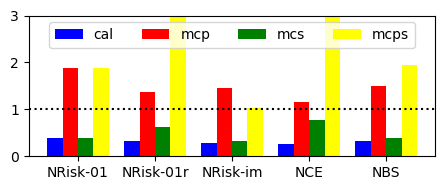

In [4]:
# Compute and plot all the overall metrics
adjusted_cost = True
metric_dict = {
    'NRisk-01': cost_01, 
    'NRisk-01r': cost_ab1, 
    'NRisk-im': cost_im, 
    'NCE': LogLoss, 
    'NBS': Brier
    }

fig, ax = plt.subplots(figsize=(4.6,2))

# set width of bar
barWidth = 0.2

for j, score_name in enumerate(score_names):

    scores = score_dict[score_name]

    xvalues = np.arange(len(metric_dict)) + barWidth * j
    yvalues = []

    for metric_name, metric in metric_dict.items():

        if 'Risk' in metric_name:
            val, decisions = ec.average_cost_for_bayes_decisions(targets, scores, metric, adjusted=adjusted_cost, silent=True)
        else:
            val = metric(scores, targets)
        if metric_name == 'NBS':
            print(score_name, val)

        yvalues.append(val)

    ax.bar(xvalues, yvalues, color =color[j], width = barWidth, label = score_name)

ax.legend(loc='upper center', ncol=4)
ax.set_xticks(np.arange(len(metric_dict)) + barWidth * 1.5, metric_dict.keys())

xvalues = ax.get_xlim()
ax.plot(xvalues, np.ones_like(xvalues), ':k')
ax.set_xlim(xvalues)
ax.set_ylim([0, min(3 if num_targets==10 else 2,ax.get_ylim()[1])])
plt.tight_layout()
plt.savefig(f"{outdir}/overall_metrics_nclasses{num_targets}.pdf")

cal [-0.5712164766030126, -0.3550436306109023, -0.622176244703909, -0.221899401800101, array(0.60279618)]
mcp [78.01647645172973, 9.350056128464376, 78.56828256835865, 5.822331435151011, array(15.60434108)]
mcs [67.12349698252376, 67.26322959229704, 19.950837928625212, 20.158272048687024, array(6.70070488)]
mcps [94.1331923018254, 75.7417941361449, 83.40779459702141, 26.88054523578379, array(32.98206156)]


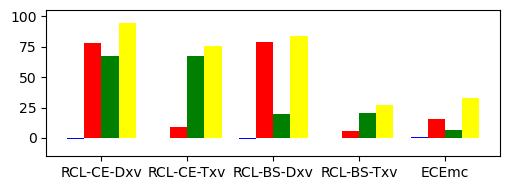

In [5]:
# Compute and plot the calibration metrics

relative_cl = True

if num_targets == 2:
    metric_dict = {'CL-BS': Brier, 
                   #'ECE-L2':  L2ECEbin, # Uncomment this if you want to compare with ECE-L2, which is comparable to RCL-BS-Htt with relative_cl=False
                   'ECEmc': ECE,
                   'ECE': ECEbin}
    calmethods = ['aff', 'his']
    traintypes = ['xv', 'tt']
else:
    metric_dict = {'CL-CE': LogLoss, 
                   'CL-BS': Brier, 
                   'ECEmc': ECE}
    calmethods = ['aff', 'tem', 'his']
    traintypes = ['xv']
        
calmethod_name = {'aff': 'D', 'tem': 'T', 'his': 'H'}  
        
if num_targets == 2:
    fig, ax = plt.subplots(figsize=(6.2,2))    
else:
    fig, ax = plt.subplots(figsize=(5.2,2))

for j, score_name in enumerate(score_names):

    scores = score_dict[score_name]

    yvalues = []
    full_metric_names = []
    
    for metric_name, metric in metric_dict.items():

        if "ECE" in metric_name:
            val = metric(scores, targets)
            full_metric_names.append(metric_name)
            yvalues.append(val)
        else:
            # For the other metrics, we have various choices on how to create the
            # calibrated scores (affcal, temcal, hiscal, each trained with xval or train
            # on test.
            for traintype in traintypes:
                for calmethod in calmethods:
                    score_name_cal = score_name + "-" + calmethod + "cal" + traintype

                    if metric_name == "CL-CE" and 'his' in calmethod: continue
                    if score_name_cal not in score_dict: continue

                    scores_cal = score_dict[score_name_cal]
                    val = CalLoss(metric, scores, scores_cal, targets, relative=relative_cl)
                    metric_name2 = f'R{metric_name}' if relative_cl else metric_name
                    full_metric_names.append(metric_name2 + "-" + calmethod_name[calmethod] + traintype)
                    yvalues.append(val)
    print(score_name, yvalues)

    xvalues = np.arange(len(full_metric_names)) + barWidth * j 
    ax.bar(xvalues, yvalues, color =color[j], width = barWidth, label = score_name)

ax.set_xticks(np.arange(len(full_metric_names)) + barWidth*1.5, full_metric_names)

ax.set_ylim([-15,105])

plt.tight_layout()

if relative_cl:
    plt.savefig(f"{outdir}/calibration_metrics_nclasses{num_targets}.pdf")
else:
    plt.legend(loc='upper left', ncol=4)
    plt.savefig(f"{outdir}/calibration_metrics_nclasses{num_targets}_absolute.pdf")
        

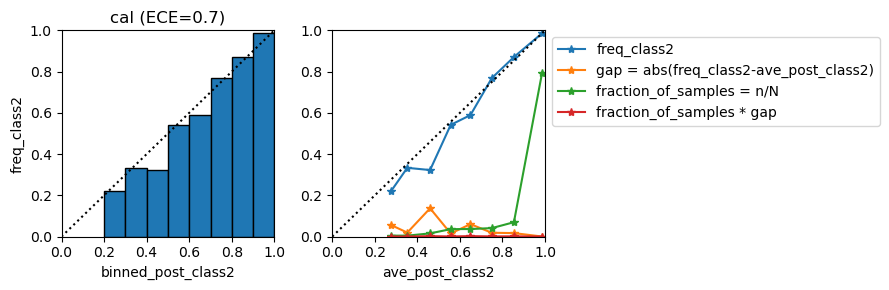

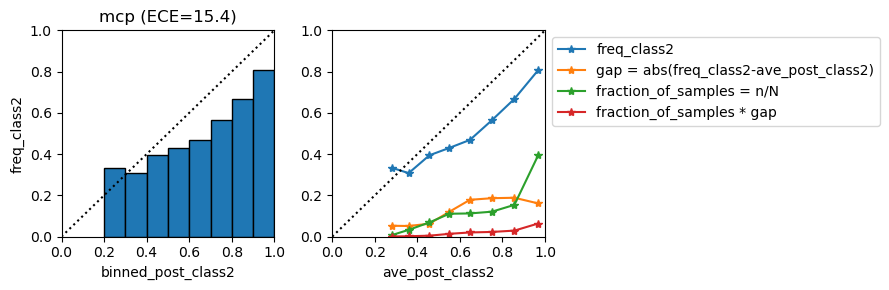

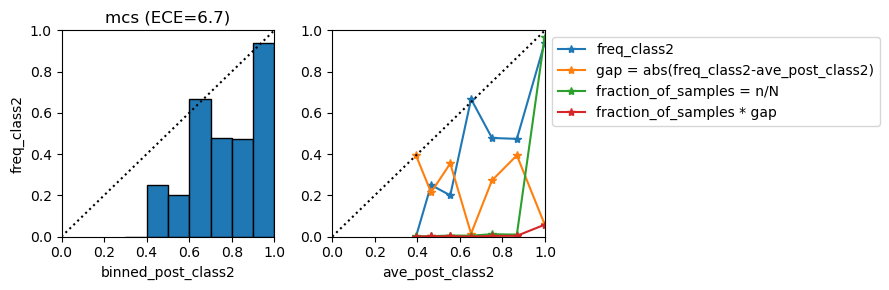

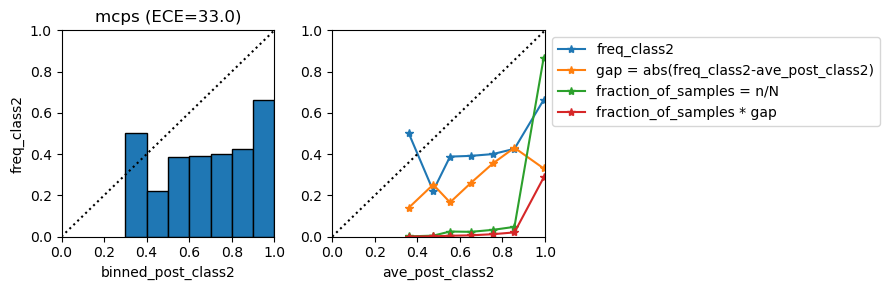

In [6]:
# Plot our version of the reliability diagram, using curves instead of bars and plotting some of the
# quantities involved in the ECE computation. The ECE is equal to the sum over all markers in the
# red curve, multiplied by 100. The usual reliability diagram is included on the right for
# comparison. The main difference is that the bars do not show the average posterior within the bar,
# which is what is actually used to compute the ECE. Further, the bars do not show the fraction of
# samples in each bin which is also used to compute the ECE. 

M = 10 # number of bins

for j, score_name in enumerate(score_names):

    scores = score_dict[score_name]
    
    if num_targets == 2:
        metric_value, ys, xs, counts, limits = ECEbin(scores, targets, return_values=True, M=M)
        plot_reliability_diagram(ys, xs, counts, limits, title=score_name, figsize=(9,3))
    else:
        metric_value, ys, xs, counts, limits = ECE(scores, targets, return_values=True, M=M)
        plot_reliability_diagram(ys, xs, counts, limits, title=score_name, figsize=(9,3))



In [7]:
# Analysis on the difference between mcp and cal system's posteriors

scores_mcp = np.exp(score_dict['mcp'])
scores_cal = np.exp(score_dict['cal'])

pred_mcp = np.argmax(scores_mcp, axis=1)
pred_cal = np.argmax(scores_cal, axis=1)

conf_mcp = np.max(scores_mcp, axis=1)
conf_cal = np.max(scores_cal, axis=1)

same_decision = pred_mcp == pred_cal

print("Fraction of samples with same decision: %.2f"%(np.sum(same_decision)/scores_mcp.shape[0]))

print(np.mean(scores_cal, axis=0))
print(np.mean(np.abs((scores_mcp - scores_cal)/scores_cal), axis=0))


Fraction of samples with same decision: 0.64
[0.80289633 0.02286545 0.02380782 0.01863524 0.02150363 0.02055147
 0.02098587 0.02087999 0.02362504 0.02424916]
[5.27064040e-01 1.61954027e+01 1.61954027e+01 1.61954027e+01
 1.61954027e+01 1.61954027e+01 1.61954027e+01 1.61954027e+01
 1.61954027e+01 1.37808126e+03]
